In [1]:
import os
import json
import glob
import copy
import copy
import itertools
import pprint 
pp = pprint.PrettyPrinter(indent=4)

import numpy as np
import pylab as pl
import seaborn as sns
import pandas as pd
import statsmodels as sm
import cPickle as pkl

from scipy import stats as spstats

from pipeline.python.classifications import experiment_classes as util
from pipeline.python.classifications import aggregate_data_stats as aggr
from pipeline.python.classifications import rf_utils as rfutils
from pipeline.python import utils as putils

from matplotlib.lines import Line2D
import matplotlib.patches as patches

In [2]:
%matplotlib notebook

In [4]:
# Set colors
visual_area, area_colors = putils.set_threecolor_palette()
dpi = putils.set_plot_params()


In [5]:
pl.rcParams['axes.labelsize']

16.0

# Dataset info

In [7]:
#### Set trace ID and FOV/state type
traceid = 'traces001'
fov_type = 'zoom2p0x'
state = 'awake'
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'

#### Responsive params
responsive_test = 'nstds' # 'nstds' #'ROC' #None
nstd_thr=10
responsive_thr = 0.05 if responsive_test=='nstds' else nstd_thr #0.05 #None
n_stds = None if responsive_test=='ROC' else 2.5 #None

response_type = 'dff'

response_str = '%s_resptest-%s_respthr-%.2f' % (response_type, responsive_test, responsive_thr) 

In [ ]:
#### Create data ID for labeling figures with data-types
experiment = 'blobs'


# Output dir

In [23]:
#### Output dir
stats_dir = os.path.join(aggregate_dir, 'data-stats')

#### Get metadata for stimulus

In [9]:
experiment = 'blobs'

In [10]:
# Get all data sets
sdata = aggr.get_aggregate_info(traceid=traceid, fov_type=fov_type, state=state)
sdata[['visual_area', 'animalid', 'session', 'fov']].drop_duplicates().groupby(['visual_area']).count()

,animalid,session,fov
visual_area,,,
Li,26,26,26
Lm,22,22,22
V1,18,18,18


In [11]:
# Get blob metadata only - and only if have RFs
sdata_exp = pd.concat([g for k, g in sdata.groupby(['animalid', 'session', 'fov']) if 
                        (experiment in g['experiment'].values 
                         and ('rfs' in g['experiment'].values or 'rfs10' in g['experiment'].values)) ])
sdata_exp['datakey'] = ['%s_%s_fov%i' % (session, animalid, fovnum) 
                              for session, animalid, fovnum in zip(sdata_exp['session'].values, 
                                                                   sdata_exp['animalid'].values,
                                                                   sdata_exp['fovnum'].values)]

sdata_exp[['visual_area', 'animalid', 'session', 'fov']].drop_duplicates().groupby(['visual_area']).count()

,animalid,session,fov
visual_area,,,
Li,13,13,13
Lm,12,12,12
V1,11,11,11


#### Drop duplicates and whatnot fovs

In [13]:
stim_filterby = 'first'

if experiment=='blobs':
    has_gratings=False
    g_str = 'hasgratings' if has_gratings else 'blobsonly'
else:
    g_str = 'gratingsonly'
filter_str = 'stim-filter-%s_%s_%s' % (stim_filterby, g_str, response_str)

In [17]:
# Drop duplicates and whatnot fovs
if experiment=='blobs':
    exp_dkeys = aggr.get_blob_datasets(filter_by=stim_filterby, has_gratings=has_gratings, as_dict=True)
elif experiment == 'gratings':
    exp_dkeys = aggr.get_gratings_datasets(filter_by=stim_filterby, as_dict=True)

for k, v in exp_dkeys.items():
    print('%s: %i datasets' % (k, len(v)))

dictkeys = [d for d in list(itertools.chain(*exp_dkeys.values()))]
stim_datakeys = ['%s_%s_fov%i' % (s.split('_')[0], s.split('_')[1], 
                   sdata[(sdata['animalid']==s.split('_')[1]) & (sdata['session']==s.split('_')[0])]['fovnum'].unique()[0]) for s in dictkeys]
expmeta = dict((k, [dv for dv in stim_datakeys for vv in v if vv in dv]) for k, v in exp_dkeys.items())

V1: 8 datasets
Lm: 8 datasets
Li: 9 datasets


In [24]:

#### Create data ID for labeling figures with data-types
data_id = '|'.join([traceid, filter_str])
print(data_id)


traces001|stim-filter-first_blobsonly_dff_resptest-nstds_respthr-0.05


In [21]:
for datakey in stim_datakeys:
    print sdata_exp[sdata_exp['datakey']==datakey]['experiment'].values

['rfs' 'gratings' 'blobs' 'retino']
['rfs' 'rfs10' 'gratings' 'blobs' 'retino']
['rfs' 'rfs10' 'gratings' 'blobs' 'retino']
['rfs' 'rfs10' 'gratings' 'blobs' 'retino']
['rfs' 'gratings' 'blobs' 'retino']
['rfs' 'rfs10' 'gratings' 'blobs' 'retino']
['blobs' 'retino' 'rfs']
['blobs' 'retino' 'rfs']
['rfs' 'gratings' 'blobs' 'retino']
['rfs' 'gratings' 'blobs' 'retino']
['rfs' 'rfs10' 'gratings' 'blobs' 'retino']
['rfs' 'gratings' 'blobs' 'retino']
['blobs' 'retino' 'rfs']
['blobs' 'retino' 'rfs']
['blobs' 'retino' 'rfs']
['blobs' 'retino' 'rfs']
['rfs10' 'gratings' 'blobs' 'retino']
['rfs10' 'gratings' 'blobs' 'retino']
['rfs10' 'gratings' 'blobs' 'retino']
['rfs10' 'gratings' 'blobs' 'retino']
['rfs10' 'gratings' 'blobs' 'retino']
['rfs' 'rfs10' 'gratings' 'blobs' 'retino']
['rfs10' 'gratings' 'blobs' 'retino']
['rfs10' 'gratings' 'blobs' 'retino']
['blobs' 'rfs']


# Load gratings or blobs

In [25]:
glob.glob(os.path.join(stats_dir, 'aggr_%s_trialmeans_*%s*_%s_stimulus.pkl' 
                                               % (experiment, responsive_test, response_type)))

['/n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/aggr_blobs_trialmeans_traces001_nstds-thr-10.00_dff_stimulus.pkl',
 '/n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/aggr_blobs_trialmeans_traces001_nstds-thr-15.00_dff_stimulus.pkl']

In [26]:
aggr_trialmeans_dfile = glob.glob(os.path.join(stats_dir, 
                                'aggr_%s_trialmeans_*%s*_%s_stimulus.pkl' 
                                               % (experiment, responsive_test, response_type)))[0]

print(aggr_trialmeans_dfile)
with open(aggr_trialmeans_dfile, 'rb') as f:
    MEANS = pkl.load(f)
    

/n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/aggr_blobs_trialmeans_traces001_nstds-thr-10.00_dff_stimulus.pkl


In [28]:
#[k for k in stim_datakeys if k not in MEANS.keys()]
[k for k in MEANS.keys() if k not in stim_datakeys]


['20190603_JC080_fov1',
 '20190510_JC083_fov1',
 '20190422_JC076_fov1',
 '20190517_JC083_fov1',
 '20190501_JC076_fov1',
 '20191008_JC091_fov1',
 '20190614_JC091_fov1',
 '20190612_JC099_fov1',
 '20190511_JC083_fov1',
 '20190509_JC078_fov1',
 '20190607_JC091_fov1',
 '20190513_JC078_fov1']

# Select stimuli

In [30]:
include_stimuli='all'

animalid = 'JC084'
session = '20190522'
fovnum = 1
datakey = '%s_%s_fov%i' % (session, animalid, fovnum)

if experiment == 'blobs':
    obj = util.Objects(animalid, session, 'FOV%i_zoom2p0x' %  fovnum, traceid=traceid)
else:
    obj = util.Gratings(animalid, session, 'FOV%i_zoom2p0x' %  fovnum, traceid=traceid)
sdf = obj.get_stimuli()

# curr_datakeys = [k for k in stim_datakeys if k not in excl]
curr_sdata = sdata_exp[sdata_exp['datakey'].isin(stim_datakeys)].copy()
print(len(curr_sdata['datakey'].unique()), len(stim_datakeys))

Creating blobs object [JC084|20190522|FOV1_zoom2p0x|traces001]
... getting stimulus info for: combined_blobs_static
(25, 25)


In [31]:
all_configs = ['config%03d' % i for i in np.arange(1, sdf.shape[0]+1)]
if experiment=='blobs':
    control_configs = ['config001', 'config002', 'config003', 'config004', 'config005']
elif experiment=='gratings':
    control_configs = sdf[sdf['size']>100].index.tolist()
    
if include_stimuli=='fullscreen':
    included_configs = [c for c in all_configs if c in control_configs]
elif include_stimuli=='image':
    included_configs = [c for c in all_configs if c not in control_configs]
elif include_stimuli=='all':
    included_configs = all_configs
else:
    print("UNKNOWN: %s" % include_stimuli)
print("Restricting stimuli to: %s (%i conditions)" % (include_stimuli, len(included_configs)))

Restricting stimuli to: all (50 conditions)


# Signal correlations

In [35]:
x_list = []
for (visual_area, animalid, session, fovnum), g in curr_sdata.groupby(['visual_area', 'animalid', 'session', 'fovnum']):

    datakey = '_'.join([session, animalid, 'fov%i' % fovnum])
    if datakey not in MEANS.keys():
        print('... missing %s' % datakey)
        continue
    trial_means = MEANS[datakey].copy() # shape: (ntrials_total, nrois_total)
    if response_type == 'corrected':
        cfg_tmp = trial_means['config']
        trial_means = putils.zscore_dataframe(trial_means)
        trial_means['config'] = cfg_tmp
    tuning_ = trial_means[trial_means['config'].isin(included_configs)].groupby(['config']).mean().reset_index()
    cc = putils.melt_square_matrix(tuning_.corr(), metric_name='corrcoef', include_diagonal=False)
    metadict={'visual_area': visual_area, 'animalid': animalid, 
              'session': session, 'fovnum': fovnum, 'datakey': datakey}
    cc = aggr.add_meta_to_df(cc, metadict)
    x_list.append(cc)
signal_corrs = pd.concat(x_list, axis=0).reset_index(drop=True)

# Get mean across animals
mean_signal_corrs = signal_corrs.groupby(['visual_area', 'datakey']).mean().reset_index()

# Get screen and stimulus info

In [36]:
screeninfo = aggr.get_aggregate_stimulation_info(expdf)
screenleft = float(screeninfo['screen_left'].unique())
screenright = float(screeninfo['screen_right'].unique())
screentop = float(screeninfo['screen_top'].unique())
screenbottom = float(screeninfo['screen_bottom'].unique())
screenaspect = float(screeninfo['screen_xres'].unique()) / float(screeninfo['screen_yres'].unique())


NameError: name 'expdf' is not defined

# Load RF fits

In [41]:
from pipeline.python.retinotopy import fit_2d_rfs as fitrf

In [55]:
from pipeline.python.rois.utils import load_roi_coords

In [49]:
reliable_only = True
#rfs_filter_by = None # Get all # match <EXP> datasets # 'drop_repeats'
rf_fit_thr = 0.05
fit_desc = fitrf.get_fit_desc(response_type=response_type)
reliable_str = 'reliable' if reliable_only else ''
rf_str = 'match%s_%s' % (experiment, reliable_str)

#### Get non-repeated FOV datasets
rf_dsets = sdata_exp[(sdata_exp['datakey'].isin(stim_datakeys))
                     & (sdata_exp['experiment'].isin(['rfs', 'rfs10']))].copy()
rf_dpaths, no_fits = rfutils.get_fit_dpaths(rf_dsets, traceid=traceid, fit_desc=fit_desc)
print("%i with no fits" % len(no_fits))

rfdf = rfutils.aggregate_rf_data(rf_dpaths, reliable_only=reliable_only, fit_desc=fit_desc,
                                            traceid=traceid, verbose=False)
rfdf = rfdf.reset_index(drop=True)

stim-filter-first_blobsonly_dff_resptest-nstds_respthr-0.05
N dpaths: 31, N unfit: 0
N datasets included: 31, N sessions excluded: 4
0 with no fits


NameError: name 'r_df' is not defined

In [62]:
rfdf = rfdf.reset_index(drop=True)

In [53]:
rf_str = 'match%s_%s' % (experiment, reliable_str)
print(rf_str)

matchblobs_reliable


# Select RFs

In [ ]:
[k for k in signal_corrs['datakey'].unique() if k not in 

expdf = #


# Get position info for RFs

In [ ]:
df_fpath = os.path.join(outdir, 'fits_and_coords_%s_%s_%s.pkl' % (filter_by, reliable_str, rfname))
print(df_fpath)

get_positions = False
if os.path.exists(df_fpath) and get_positions is False:
    print("Loading existing RF coord conversions...")
    try:
        with open(df_fpath, 'rb') as f:
            df = pkl.load(f)
    except Exception as e:
        get_positions = True
print(get_positions)

In [81]:
#if get_positions:
print("Calculating RF coord conversions...")
pos_params = ['fov_xpos', 'fov_xpos_pix', 'fov_ypos', 'fov_ypos_pix', 'ml_pos','ap_pos']
for p in pos_params:
    rfdf[p] = ''
p_list=[]
for (animalid, session, fovnum), g in rfdf.groupby(['animalid', 'session', 'fovnum']):
    fcoords = load_roi_coords(animalid, session, 'FOV%i_zoom2p0x' % fovnum, 
                              traceid=traceid, create_new=False)

    for ei, e_df in g.groupby(['experiment']):
        cell_ids = e_df['cell'].unique()
        p_ = fcoords['roi_positions'].loc[cell_ids]
        for p in pos_params:
            rfdf[p][e_df.index] = p_[p].values
# with open(df_fpath, 'wb') as f:
#     pkl.dump(expdf, f, protocol=pkl.HIGHEST_PROTOCOL)

Calculating RF coord conversions...
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords


In [101]:
r_list=[]
for datakey in MEANS.keys():
    rdf = rfdf[rfdf['datakey']==datakey].copy()
    if len(rdf['experiment'].unique())>1:
        print(datakey, rdf['experiment'].unique())
        rdf.groupby(['experiment']).count()
        rfname = rdf[['experiment', 'cell']].groupby(['experiment']).count().idxmax()[0]
        r_list.append(rdf[rdf['experiment']==rfname])
    else:
        r_list.append(rdf)
RFs = pd.concat(r_list, axis=0)


('20190613_JC097_fov1', array(['rfs', 'rfs10'], dtype=object))
('20190622_JC085_fov1', array(['rfs', 'rfs10'], dtype=object))
('20190618_JC097_fov1', array(['rfs', 'rfs10'], dtype=object))
('20190602_JC091_fov1', array(['rfs', 'rfs10'], dtype=object))
('20190616_JC097_fov1', array(['rfs', 'rfs10'], dtype=object))
('20191006_JC110_fov1', array(['rfs', 'rfs10'], dtype=object))


In [151]:
r_list=[]
for datakey, expdf in signal_corrs.groupby(['datakey']):
    #print(datakey)
    # Get active blob cells
    exp_rids = sorted(np.union1d(expdf['row'].unique(), expdf['col'].unique()))
    
    # Get current fov's RFs
    rdf = rfdf[rfdf['datakey']==datakey].copy()
    
    # If have both rfs/rfs10, pick the best one
    if len(rdf['experiment'].unique())>1:
        rf_rids = rdf[rdf['experiment']=='rfs']['cell'].unique()
        rf10_rids = rdf[rdf['experiment']=='rfs10']['cell'].unique()
        same_as_rfs = np.intersect1d(rf_rids, exp_rids)
        same_as_rfs10 = np.intersect1d(rf10_rids, exp_rids)
        rfname = 'rfs' if len(same_as_rfs) > len(same_as_rfs10) else 'rfs10'
        print("Selecting %s, overlappig rfs, %i | rfs10, %i (of %i cells)" 
              % (rfname, len(same_as_rfs), len(same_as_rfs10), len(exp_rids)))
        r_list.append(rdf[rdf['experiment']==rfname])
    else:
        r_list.append(rdf)
RFs = pd.concat(r_list, axis=0)
#RFs['cell'] = RFs['cell'].astype(float)

Selecting rfs10, overlappig rfs, 33 | rfs10, 59 (of 241 cells)
Selecting rfs10, overlappig rfs, 61 | rfs10, 88 (of 166 cells)
Selecting rfs10, overlappig rfs, 98 | rfs10, 119 (of 296 cells)
Selecting rfs10, overlappig rfs, 13 | rfs10, 24 (of 116 cells)
Selecting rfs10, overlappig rfs, 26 | rfs10, 97 (of 203 cells)
Selecting rfs10, overlappig rfs, 46 | rfs10, 72 (of 217 cells)


In [132]:
print(rfdf.shape, RFs.shape)

((1553, 28), (1254, 28))


In [133]:
RFs[['visual_area', 'datakey']].drop_duplicates().groupby(['visual_area']).count()

,datakey
visual_area,
Li,9
Lm,8
V1,8


In [134]:
rfdf[['visual_area', 'datakey']].drop_duplicates().groupby(['visual_area']).count()

,datakey
visual_area,
Li,9
Lm,8
V1,8


# Calculate overlap % bw cell pairs

In [135]:
rf_fit_params = ['cell', 'std_x', 'std_y', 'theta', 'x0', 'y0']
n_dks = len(RFs['datakey'].unique())

o_list=[]
for di, ((visual_area, animalid, session, fovnum, datakey), g) in enumerate(RFs.groupby(['visual_area', 'animalid', 'session', 'fovnum', 'datakey'])):
    if di%10==0:
        print("... %i of %i" % (int(di+1), n_dks))
        
    # convert RF fit params to polygon
    g.index = g['cell'].values
    rf_polys = rfutils.rfs_to_polys(g[rf_fit_params])

    # Get all pairwise overlaps (% of smaller ellipse that overlaps larger ellipse)
    pair_ixs = list(itertools.combinations(np.arange(0, len(rf_polys)), 2))
    overlaps = pd.concat([rfutils.get_proportion_overlap(rf_polys[p1], rf_polys[p2]) for (p1, p2) in pair_ixs], axis=0)
    metadict={'visual_area': visual_area, 'animalid': animalid, 
              'session': session, 'fovnum': fovnum, 'datakey': datakey}
    o_ = putils.add_meta_to_df(overlaps, metadict)
    o_list.append(o_)

overlaps = pd.concat(o_list, axis=0).reset_index(drop=True)

... 1 of 25
... 11 of 25
... 21 of 25


# Add distance info between pairs

In [327]:
datakeys = overlaps['datakey'].unique()
overlaps['distance'] = ''

x_list = []
for di, (datakey, overlap_) in enumerate(overlaps.groupby(['datakey'])):
    if di%5==0:
        print('%i of %i dsets' % (int(di+1), n_dks))
    
    #if datakey != '20190522_JC084_fov1':
    #    continue
    overlap_ = overlaps[overlaps['datakey']==datakey]

    rfs_ = RFs[RFs['datakey']==datakey].copy()
    rfs_.index=rfs_['cell'].values

    # Get cell ids common to EXP and RFs
    exp_rids = sorted([r for r in MEANS[datakey].columns if putils.isnumber(r)])
    rf_rids = sorted(np.union1d(overlap_['row'].unique(), overlap_['col'].unique()))
    common_rids = sorted(np.intersect1d(exp_rids, rf_rids)) 
    if len(common_rids) < 2:
        print("No pairs: %s (exp has %i, rfs has %i)" % (datakey, len(exp_rids), len(rf_rids)))
    else:
        print("[%s] %i common cells" % (datakey, len(common_rids)))

    # Get signal corr values for current overlap pairs
    sig = signal_corrs[signal_corrs['datakey']==datakey].copy()
    i_list = [sig[((sig['row']==r1) & (sig['col']==r2)) | ((sig['col']==r1) & (sig['row']==r2))] \
              for (r1, r2), gg in overlap_.groupby(['row', 'col'])]
    sigs_with_rfs = pd.concat(i_list, axis=0)
    
    if len(sigs_with_rfs)==0:
        continue
    # Group by same pair ordering, and add the corresponding overlap_ entries
    overlap_and_sig = pd.concat([gg for (r1, r2), gg in overlap_.groupby(['row', 'col']) \
                         if len(sig[((sig['row']==r1) & (sig['col']==r2)) | ((sig['col']==r1) & (sig['row']==r2))])>0])
    # Merge them
    merger = pd.merge(sigs_with_rfs, overlap_and_sig)    

    # Coords of cell1 in pair, in order
    coords1 = np.array(rfs_.loc[merger['row'].values][['ml_pos', 'ap_pos']])
    # Coords of cell2 in pair 
    coords2 = np.array(rfs_.loc[merger['col'].values][['ml_pos', 'ap_pos']])

    # Get dists, in order of appearance
    dists = [np.linalg.norm(c1-c2) for c1, c2 in zip(coords1, coords2)]
    merger['distance'] = dists #d_df['distance'].values
    #print(merger.head())
    print(merger.shape)
    
    x_list.append(merger)
roi_df = pd.concat(x_list, axis=0)


1 of 25 dsets
[20190420_JC076_fov1] 30 common cells
(435, 11)
[20190430_JC078_fov1] 31 common cells
(465, 11)
[20190502_JC076_fov1] 15 common cells
(105, 11)
[20190504_JC078_fov1] 10 common cells
(45, 11)
[20190506_JC080_fov1] 31 common cells
(465, 11)
6 of 25 dsets
[20190507_JC083_fov1] 55 common cells
(1485, 11)
[20190508_JC083_fov1] 61 common cells
(1830, 11)
[20190512_JC083_fov1] 39 common cells
(741, 11)
[20190522_JC084_fov1] 107 common cells
(5671, 11)
[20190525_JC084_fov1] 36 common cells
(630, 11)
11 of 25 dsets
[20190602_JC091_fov1] 59 common cells
(1711, 11)
[20190605_JC090_fov1] 9 common cells
(36, 11)
[20190606_JC091_fov1] 26 common cells
(325, 11)
[20190609_JC099_fov1] 22 common cells
(231, 11)
[20190613_JC097_fov1] 88 common cells
(3828, 11)
16 of 25 dsets
[20190616_JC097_fov1] 119 common cells
(7021, 11)
[20190617_JC097_fov1] 84 common cells
(3486, 11)
[20190617_JC099_fov1] 4 common cells
(6, 11)
[20190618_JC097_fov1] 24 common cells
(276, 11)
[20190622_JC085_fov1] 97 co

ValueError: No objects to concatenate

In [328]:
sigs_with_rfs

,row,col,corrcoef,session,datakey,visual_area,fovnum,animalid


In [329]:
roi_df = pd.concat(x_list, axis=0)
print(roi_df.shape)
roi_df.head()

(36034, 11)


,row,col,corrcoef,session,datakey,visual_area,fovnum,animalid,area_overlap,perc_overlap,distance
0,7,24,0.655716,20190420,20190420_JC076_fov1,V1,1,JC076,1036.280440,0.907661,268.132066
1,7,25,0.138366,20190420,20190420_JC076_fov1,V1,1,JC076,1260.666831,0.897161,312.988786
2,7,26,0.369180,20190420,20190420_JC076_fov1,V1,1,JC076,1098.959686,0.782081,280.435363
3,7,32,0.234836,20190420,20190420_JC076_fov1,V1,1,JC076,1134.460302,0.927412,458.066500
4,7,42,-0.323832,20190420,20190420_JC076_fov1,V1,1,JC076,909.171355,0.966212,187.246909


In [335]:
pd.qcut(roi_df['perc_overlap'], 5, labels=False)

0       2
1       2
2       1
3       2
4       3
5       4
6       3
7       4
8       3
9       3
10      0
11      2
12      1
13      2
14      2
15      1
16      3
17      0
18      4
19      4
20      2
21      2
22      3
23      2
24      1
25      2
26      2
27      3
28      1
29      3
       ..
2541    4
2542    2
2543    3
2544    4
2545    2
2546    4
2547    4
2548    4
2549    3
2550    1
2551    3
2552    0
2553    3
2554    1
2555    4
0       0
1       0
2       4
3       0
4       4
5       0
6       4
7       3
8       4
9       4
10      4
11      2
12      0
13      0
14      0
Name: perc_overlap, Length: 36034, dtype: int64

# Plot

In [336]:
n_bins_dist = 10
n_bins_overlap = 5

use_quartile=True

if use_quartile:
    roi_df['binned_dist'] = pd.qcut(roi_df['distance'], n_bins_dist, labels=False)
    roi_df['binned_overlap'] = pd.qcut(roi_df['perc_overlap'], n_bins_overlap, labels=False)
else:
    roi_df['binned_dist'] = pd.cut(roi_df['distance'], n_bins_dist, labels=False)
    roi_df['binned_overlap'] = pd.cut(roi_df['perc_overlap'], n_bins_overlap, labels=False)

#_, bin_sizes = pd.qcut(tuning_corrcoefs['distance'], n_bins, retbins=True)
#bin_edges = bin_sizes[0:-1]
params = ['perc_overlap', 'area_overlap', 'distance', 'binned_dist']
for p in params:
    roi_df[p] = roi_df[p].astype(float)

In [337]:
roi_df.groupby(['visual_area', 'datakey']).count()

row   col  corrcoef  session  fovnum  \
visual_area datakey                                                      
Li          20190502_JC076_fov1   105   105       105      105     105   
            20190602_JC091_fov1  1711  1711      1711     1711    1711   
            20190605_JC090_fov1    36    36        36       36      36   
            20190606_JC091_fov1   325   325       325      325     325   
            20190609_JC099_fov1   231   231       231      231     231   
            20190617_JC099_fov1     6     6         6        6       6   
            20191018_JC113_fov1    15    15        15       15      15   
Lm          20190430_JC078_fov1   465   465       465      465     465   
            20190504_JC078_fov1    45    45        45       45      45   
            20190506_JC080_fov1   465   465       465      465     465   
            20190508_JC083_fov1  1830  1830      1830     1830    1830   
            20190512_JC083_fov1   741   741       741      741     741   
            20190525_JC084_fov1   630   630       630      630     630   
            20190618_JC097_fov1   276   276       276      276     276   
            20190627_JC091_fov1    15    15        15       15      15   
V1          20190420_JC076_fov1   435   435       435      435     435   
            20190507_JC083_fov1  1485  1485      1485     1485    1485   
            20190522_JC084_fov1  5671  5671      5671     5671    5671   
            20190613_JC097_fov1  3828  3828      3828     3828    3828   
            20190616_JC097_fov1  7021  7021      7021     7021    7021   
            20190617_JC097_fov1  3486  3486      3486     3486    3486   
            20190622_JC085_fov1  4656  4656      4656     4656    4656   
            20191006_JC110_fov1  2556  2556      2556     2556    2556   

                                 animalid  area_overlap  perc_overlap  \
visual_area datakey                                                     
Li          20190502_JC076_fov1       105           105           105   
            20190602_JC091_fov1      1711          1711          1711   
            20190605_JC090_fov1        36            36            36   
            20190606_JC091_fov1       325           325           325   
            20190609_JC099_fov1       231           231           231   
            20190617_JC099_fov1         6             6             6   
            20191018_JC113_fov1        15            15            15   
Lm          20190430_JC078_fov1       465           465           465   
            20190504_JC078_fov1        45            45            45   
            20190506_JC080_fov1       465           465           465   
            20190508_JC083_fov1      1830          1830          1830   
            20190512_JC083_fov1       741           741           741   
            20190525_JC084_fov1       630           630           630   
            20190618_JC097_fov1       276           276           276   
            20190627_JC091_fov1        15            15            15   
V1          20190420_JC076_fov1       435           435           435   
            20190507_JC083_fov1      1485          1485          1485   
            20190522_JC084_fov1      5671          5671          5671   
            20190613_JC097_fov1      3828          3828          3828   
            20190616_JC097_fov1      7021          7021          7021   
            20190617_JC097_fov1      3486          3486          3486   
            20190622_JC085_fov1      4656          4656          4656   
            20191006_JC110_fov1      2556          2556          2556   

                                 distance  binned_dist  binned_overlap  
visual_area datakey                                                     
Li          20190502_JC076_fov1       105          105             105  
            20190602_JC091_fov1      1711         1711            1711  
            20190605_JC090_fov1        36           36           

<IPython.core.display.Javascript object>


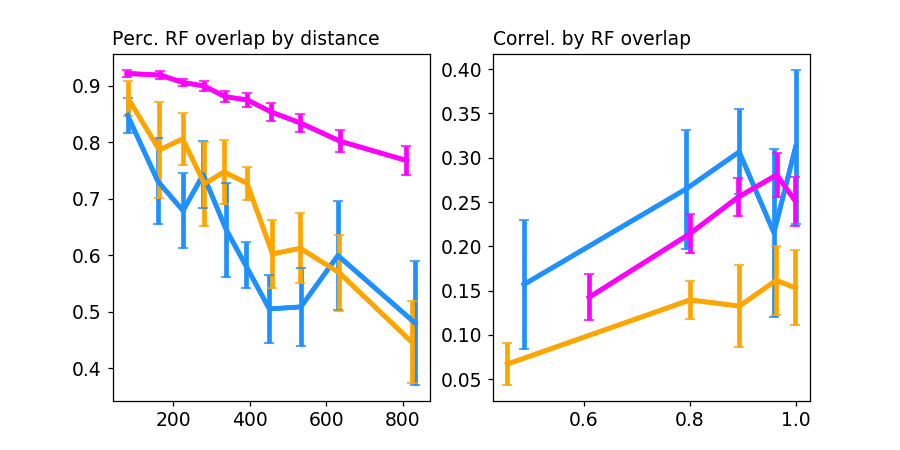

Text(0,1,u'Correl. by RF overlap')

In [344]:
use_std = False

fig, axn = pl.subplots(1, 2, figsize=(8,4), sharex=False, sharey=False, dpi=dpi)
ax = axn[0]

x_metric = 'binned_dist'
y_metric = 'perc_overlap'
fig_title = 'Perc. RF overlap by distance'

x_labeler = 'distance' if x_metric == 'binned_dist' else 'perc_overlap'
for visual_area, rdf in roi_df.groupby(['visual_area']):
    
    ncells_t = sum([len(g['row'].unique()) for dk, g in rdf.groupby(['datakey'])])
    
    # Get binned x-axis values for labeling
    bin_dists = [b_df.groupby(['datakey'])[x_labeler].mean().mean() for b, b_df in rdf.groupby([x_metric])]
    
    # Get corresponding y-value averages
    bin_ccs = [b_df.groupby(['datakey'])[y_metric].mean().mean() for b, b_df in rdf.groupby([x_metric])]
    
    # .. and error bars
    bin_sems = [spstats.sem(b_df.groupby(['datakey'])[y_metric].mean()) for b, b_df in rdf.groupby([x_metric])]
    bin_stds = [b_df.groupby(['datakey'])[y_metric].mean().std() for b, b_df in rdf.groupby([x_metric])]
    bin_errs = bin_stds if use_std else bin_sems
    
    # Plot
    ax.plot(bin_dists, bin_ccs, color=area_colors[visual_area], 
           label='%s (%i)' % (visual_area, ncells_t), lw=3)
    ax.errorbar(bin_dists, bin_ccs, yerr=bin_errs, color=area_colors[visual_area], lw=3, capsize=3)
ax.set_title(fig_title, fontsize=12, loc='left')


ax = axn[1]
x_metric = 'binned_overlap'
y_metric = 'corrcoef'
fig_title = 'Correl. by RF overlap'

x_labeler = 'distance' if x_metric == 'binned_dist' else 'perc_overlap'

for visual_area, rdf in roi_df.groupby(['visual_area']):
    
    ncells_t = sum([len(g['row'].unique()) for dk, g in rdf.groupby(['datakey'])])
    
    # Get binned x-axis values for labeling
    bin_dists = [b_df.groupby(['datakey'])[x_labeler].mean().mean() for b, b_df in rdf.groupby([x_metric])]
    
    # Get corresponding y-value averages
    bin_ccs = [b_df.groupby(['datakey'])[y_metric].mean().mean() for b, b_df in rdf.groupby([x_metric])]
    
    # .. and error bars
    bin_sems = [spstats.sem(b_df.groupby(['datakey'])[y_metric].mean()) for b, b_df in rdf.groupby([x_metric])]
    bin_stds = [b_df.groupby(['datakey'])[y_metric].mean().std() for b, b_df in rdf.groupby([x_metric])]
    bin_errs = bin_stds if use_std else bin_sems
    
    # Plot
    ax.plot(bin_dists, bin_ccs, color=area_colors[visual_area], 
           label='%s (%i)' % (visual_area, ncells_t), lw=3)
    ax.errorbar(bin_dists, bin_ccs, yerr=bin_errs, color=area_colors[visual_area], lw=3, capsize=3)
ax.set_title(fig_title, fontsize=12, loc='left')



In [343]:
bin_ccs

[0.14251137775082801,
 0.21416458481146194,
 0.25517784195265875,
 0.28067622778481333,
 0.25086605055587713]

In [342]:
bin_dists

[0.61035640975849659,
 0.80009963110129689,
 0.89060525735830787,
 0.96428896168694922,
 0.9996889870704333]

In [323]:
#datakey = '20190508_JC083_fov1'
datakey = '20190522_JC084_fov1'

overlap_ = overlaps[overlaps['datakey']==datakey]

rfs_ = RFs[RFs['datakey']==datakey].copy()
rfs_.index=rfs_['cell'].values

# Get cell ids common to EXP and RFs
exp_rids = sorted([r for r in MEANS[datakey].columns if putils.isnumber(r)])
rf_rids = sorted(np.union1d(overlap_['row'].unique(), overlap_['col'].unique()))
common_rids = sorted(np.intersect1d(exp_rids, rf_rids)) 
if len(common_rids) < 2:
    print("No pairs: %s (exp has %i, rfs has %i)" % (datakey, len(exp_rids), len(rf_rids)))
else:
    print("[%s] %i common cells" % (datakey, len(common_rids)))

# Get signal corr values for current overlap pairs
sig = signal_corrs[signal_corrs['datakey']==datakey].copy()
i_list = [sig[((sig['row']==r1) & (sig['col']==r2)) | ((sig['col']==r1) & (sig['row']==r2))] \
          for (r1, r2), gg in overlap_.groupby(['row', 'col'])]
sigs_with_rfs = pd.concat(i_list, axis=0)

# Group by same pair ordering, and add the corresponding overlap_ entries
overlap_and_sig = pd.concat([gg for (r1, r2), gg in overlap_.groupby(['row', 'col']) \
                     if len(sig[((sig['row']==r1) & (sig['col']==r2)) | ((sig['col']==r1) & (sig['row']==r2))])>0])
# Merge them
merger = pd.merge(sigs_with_rfs, overlap_and_sig)    

# Coords of cell1 in pair, in order
coords1 = np.array(rfs_.loc[merger['row'].values][['ml_pos', 'ap_pos']])
# Coords of cell2 in pair 
coords2 = np.array(rfs_.loc[merger['col'].values][['ml_pos', 'ap_pos']])

# Get dists, in order of appearance
dists = [np.linalg.norm(c1-c2) for c1, c2 in zip(coords1, coords2)]
merger['distance'] = dists #d_df['distance'].values
print(merger.head())

[20190522_JC084_fov1] 107 common cells
  row col  corrcoef   session              datakey visual_area  fovnum  \
0   1   5  0.321686  20190522  20190522_JC084_fov1          V1       1   
1   1   9  0.737909  20190522  20190522_JC084_fov1          V1       1   
2   1  10  0.287018  20190522  20190522_JC084_fov1          V1       1   
3   1  11  0.547378  20190522  20190522_JC084_fov1          V1       1   
4   1  12  0.658772  20190522  20190522_JC084_fov1          V1       1   

  animalid  area_overlap  perc_overlap    distance  
0    JC084   1470.761520      0.827003  116.218238  
1    JC084   1388.862733      0.922499  214.881459  
2    JC084   1189.789795      0.970156  218.839164  
3    JC084   1282.980922      0.908983  234.798194  
4    JC084   1189.354422      0.929392  271.777013  


In [298]:
#datakey = '20190605_JC090_fov1'
datakey = '20190522_JC084_fov1'
overlap_ = overlaps[overlaps['datakey']==datakey].copy()
sig = signal_corrs[signal_corrs['datakey']==datakey].copy()
i_list = [sig[((sig['row']==r1) & (sig['col']==r2)) | ((sig['col']==r1) & (sig['row']==r2))] \
          for (r1, r2), gg in overlap_.groupby(['row', 'col'])]

svs = pd.concat(i_list, axis=0)

In [299]:
# Group by same pair ordering, and add the corresponding overlap_ entries
overlap_and_sig = pd.concat([gg for (r1, r2), gg in overlap_.groupby(['row', 'col']) \
                     if len(sig[((sig['row']==r1) & (sig['col']==r2)) | ((sig['col']==r1) & (sig['row']==r2))])>0 ])


In [300]:
print(overlap_and_sig.shape)
overlap_and_sig.head()

(5671, 10)


,area_overlap,col,perc_overlap,row,session,datakey,visual_area,fovnum,animalid,distance
12921,1470.761520,5.0,0.827003,1.0,20190522,20190522_JC084_fov1,V1,1,JC084,
12922,1388.862733,9.0,0.922499,1.0,20190522,20190522_JC084_fov1,V1,1,JC084,
12923,1189.789795,10.0,0.970156,1.0,20190522,20190522_JC084_fov1,V1,1,JC084,
12924,1282.980922,11.0,0.908983,1.0,20190522,20190522_JC084_fov1,V1,1,JC084,
12925,1189.354422,12.0,0.929392,1.0,20190522,20190522_JC084_fov1,V1,1,JC084,


In [301]:
print(svs.shape)
svs.head()

(5671, 8)


,row,col,corrcoef,session,datakey,visual_area,fovnum,animalid
219699,1,5,0.321686,20190522,20190522_JC084_fov1,V1,1,JC084
219702,1,9,0.737909,20190522,20190522_JC084_fov1,V1,1,JC084
219703,1,10,0.287018,20190522,20190522_JC084_fov1,V1,1,JC084
219704,1,11,0.547378,20190522,20190522_JC084_fov1,V1,1,JC084
219705,1,12,0.658772,20190522,20190522_JC084_fov1,V1,1,JC084


In [302]:
merger = pd.merge(svs, overlap_and_sig)

In [303]:
merger.head()

,row,col,corrcoef,session,datakey,visual_area,fovnum,animalid,area_overlap,perc_overlap,distance
0,1,5,0.321686,20190522,20190522_JC084_fov1,V1,1,JC084,1470.761520,0.827003,
1,1,9,0.737909,20190522,20190522_JC084_fov1,V1,1,JC084,1388.862733,0.922499,
2,1,10,0.287018,20190522,20190522_JC084_fov1,V1,1,JC084,1189.789795,0.970156,
3,1,11,0.547378,20190522,20190522_JC084_fov1,V1,1,JC084,1282.980922,0.908983,
4,1,12,0.658772,20190522,20190522_JC084_fov1,V1,1,JC084,1189.354422,0.929392,


In [260]:
datakey

'20190605_JC090_fov1'

In [261]:
rfs_ = RFs[RFs['datakey']==datakey].copy()
rfs_.index=rfs_['cell'].values


In [262]:
# Coords of cell1 in pair, in order
coords1 = np.array(rfs_.loc[merger['row'].values][['ml_pos', 'ap_pos']])
# Coords of cell2 in pair 
coords2 = np.array(rfs_.loc[merger['col'].values][['ml_pos', 'ap_pos']])

# Get dists, in order of appearance
dists = [np.linalg.norm(c1-c2) for c1, c2 in zip(coords1, coords2)]
merger['distance'] = dists #d_df['distance'].values


In [263]:
merger

,row,col,corrcoef,session,datakey,visual_area,fovnum,animalid,area_overlap,perc_overlap,distance
0,13,17,-0.233838,20190605,20190605_JC090_fov1,Li,1,JC090,2223.941920,0.670171,55.438922
1,13,86,0.471935,20190605,20190605_JC090_fov1,Li,1,JC090,2690.367996,0.752410,184.290800
2,13,111,0.716179,20190605,20190605_JC090_fov1,Li,1,JC090,674.741627,0.351507,315.578664
3,13,116,0.031129,20190605,20190605_JC090_fov1,Li,1,JC090,1064.576997,0.435141,336.589925
4,13,140,-0.201327,20190605,20190605_JC090_fov1,Li,1,JC090,2553.496781,0.714132,232.526318
5,13,157,0.205934,20190605,20190605_JC090_fov1,Li,1,JC090,1303.868298,0.364651,289.536590
6,13,194,0.358677,20190605,20190605_JC090_fov1,Li,1,JC090,253.165229,0.093854,405.129840
7,13,249,0.230634,20190605,20190605_JC090_fov1,Li,1,JC090,1330.954177,0.372226,584.394007
8,17,86,-0.298036,20190605,20190605_JC090_fov1,Li,1,JC090,2862.162670,0.862495,230.779637
9,17,111,-0.305051,20190605,20190605_JC090_fov1,Li,1,JC090,1458.103344,0.759600,365.079799


In [ ]:
rfs_

In [181]:
sig = signal_corrs[signal_corrs['datakey']==datakey].copy()
print(datakey)

20191111_JC120_fov1


In [182]:
currdf = overlaps[overlaps['datakey']==datakey].copy()
currdf['row'] = currdf['row'].astype(int)
currdf['col'] = currdf['col'].astype(int)

print(datakey)
currdf[['row', 'col']].values

20191111_JC120_fov1


array([[ 66,  75],
       [ 66,  84],
       [ 66, 183],
       [ 75,  84],
       [ 75, 183],
       [ 84, 183]])

In [183]:
currdf.shape, sig.shape

((6, 9), (325, 8))

In [184]:
sig.head()

,row,col,corrcoef,session,datakey,visual_area,fovnum,animalid
65931,0,1,-0.233683,20191111,20191111_JC120_fov1,Li,1,JC120
65932,0,2,0.257858,20191111,20191111_JC120_fov1,Li,1,JC120
65933,0,3,-0.240068,20191111,20191111_JC120_fov1,Li,1,JC120
65934,0,7,-0.294888,20191111,20191111_JC120_fov1,Li,1,JC120
65935,0,8,0.087654,20191111,20191111_JC120_fov1,Li,1,JC120


In [193]:
sig.index = [tuple(i) for i in sig[['row', 'col']].values]
sig.head()

,row,col,corrcoef,session,datakey,visual_area,fovnum,animalid
"(0, 1)",0,1,-0.233683,20191111,20191111_JC120_fov1,Li,1,JC120
"(0, 2)",0,2,0.257858,20191111,20191111_JC120_fov1,Li,1,JC120
"(0, 3)",0,3,-0.240068,20191111,20191111_JC120_fov1,Li,1,JC120
"(0, 7)",0,7,-0.294888,20191111,20191111_JC120_fov1,Li,1,JC120
"(0, 8)",0,8,0.087654,20191111,20191111_JC120_fov1,Li,1,JC120


In [189]:
ris = sorted(np.union1d(sig['col'].unique(), sig['row'].unique()))
print(ris)

[0, 1, 2, 3, 7, 8, 11, 13, 25, 26, 32, 34, 39, 40, 49, 54, 55, 56, 64, 67, 77, 90, 100, 106, 175, 183]


In [190]:
ris2 = sorted(np.union1d(currdf['col'].unique(), currdf['row'].unique()))
print(ris2)

[66, 75, 84, 183]


In [194]:
currdf.index = [tuple(i) for i in currdf[['row', 'col']].values]
currdf.head()

,area_overlap,col,perc_overlap,row,session,datakey,visual_area,fovnum,animalid
"(66, 75)",1313.024244,75,0.634274,66,20191111,20191111_JC120_fov1,Li,1,JC120
"(66, 84)",429.285858,84,0.194965,66,20191111,20191111_JC120_fov1,Li,1,JC120
"(66, 183)",1530.149184,183,0.733601,66,20191111,20191111_JC120_fov1,Li,1,JC120
"(75, 84)",0.000000,84,0.000000,75,20191111,20191111_JC120_fov1,Li,1,JC120
"(75, 183)",1272.745091,183,0.614816,75,20191111,20191111_JC120_fov1,Li,1,JC120


In [195]:
currdf.shape, sig.shape

((6, 9), (325, 8))

In [198]:
[i for i in currdf.index if i not in sig.index and (i[1], i[0]) not in sig.index]

[(66, 75), (66, 84), (66, 183), (75, 84), (75, 183), (84, 183)]

In [200]:
sig

,row,col,corrcoef,session,datakey,visual_area,fovnum,animalid
"(0, 1)",0,1,-0.233683,20191111,20191111_JC120_fov1,Li,1,JC120
"(0, 2)",0,2,0.257858,20191111,20191111_JC120_fov1,Li,1,JC120
"(0, 3)",0,3,-0.240068,20191111,20191111_JC120_fov1,Li,1,JC120
"(0, 7)",0,7,-0.294888,20191111,20191111_JC120_fov1,Li,1,JC120
"(0, 8)",0,8,0.087654,20191111,20191111_JC120_fov1,Li,1,JC120
"(0, 11)",0,11,-0.029416,20191111,20191111_JC120_fov1,Li,1,JC120
"(0, 13)",0,13,-0.298059,20191111,20191111_JC120_fov1,Li,1,JC120
"(0, 25)",0,25,0.011770,20191111,20191111_JC120_fov1,Li,1,JC120
"(0, 26)",0,26,0.295513,20191111,20191111_JC120_fov1,Li,1,JC120
"(0, 32)",0,32,0.069583,20191111,20191111_JC120_fov1,Li,1,JC120


In [199]:
currdf

,area_overlap,col,perc_overlap,row,session,datakey,visual_area,fovnum,animalid
"(66, 75)",1313.024244,75,0.634274,66,20191111,20191111_JC120_fov1,Li,1,JC120
"(66, 84)",429.285858,84,0.194965,66,20191111,20191111_JC120_fov1,Li,1,JC120
"(66, 183)",1530.149184,183,0.733601,66,20191111,20191111_JC120_fov1,Li,1,JC120
"(75, 84)",0.000000,84,0.000000,75,20191111,20191111_JC120_fov1,Li,1,JC120
"(75, 183)",1272.745091,183,0.614816,75,20191111,20191111_JC120_fov1,Li,1,JC120
"(84, 183)",0.000000,183,0.000000,84,20191111,20191111_JC120_fov1,Li,1,JC120
